In [3]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import dash
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State
import plotly.express as px

In [4]:
company = 'GOOGL'

start_time = dt.datetime(2012, 1, 1)
end_time = dt.datetime(2020, 1, 1)

In [5]:
data = yf.download(company, start_time, end_time)

[*********************100%***********************]  1 of 1 completed


In [6]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.339840,16.720470,16.325577,16.651901,16.651901,146912940
2012-01-04,16.642391,16.773024,16.532032,16.723724,16.723724,114445440
2012-01-05,16.569820,16.615866,16.422173,16.491741,16.491741,131184684
2012-01-06,16.495245,16.516518,16.261011,16.266768,16.266768,107608284
2012-01-09,16.178679,16.191191,15.546296,15.577077,15.577077,232671096
...,...,...,...,...,...,...
2019-12-24,67.510498,67.600502,67.208504,67.221497,67.221497,13468000
2019-12-26,67.327499,68.160004,67.275497,68.123497,68.123497,23662000
2019-12-27,68.199997,68.352501,67.650002,67.732002,67.732002,23212000


In [7]:
scaler = MinMaxScaler(feature_range= (0, 1))

In [8]:
scaled_data = scaler.fit_transform(data.Close.values.reshape(-1,1))

prediction_days = 60



In [9]:
X_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])

In [10]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [12]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))


In [13]:
model.compile(optimizer= 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs= 25, batch_size = 32)

Epoch 1/25
61/61 [==============================] - 6s 32ms/step - loss: 0.0218
Epoch 2/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0035
Epoch 3/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0030
Epoch 4/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0030
Epoch 5/25
61/61 [==============================] - 2s 33ms/step - loss: 0.0027
Epoch 6/25
61/61 [==============================] - 2s 33ms/step - loss: 0.0027
Epoch 7/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0026
Epoch 8/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0024
Epoch 9/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0023
Epoch 10/25
61/61 [==============================] - 2s 32ms/step - loss: 0.0026
Epoch 11/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0025
Epoch 12/25
61/61 [==============================] - 2s 31ms/step - loss: 0.0020
Epoch 13/25
61/61 [==================

In [14]:
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

In [15]:
test_data = yf.download(company, test_start, test_end)

actual_prices = test_data['Close'].values

total_data = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_input = total_data[len(total_data)- len(test_data) - prediction_days : ].values

model_input = model_input.reshape(-1, 1)

model_input = scaler.transform(model_input)

[*********************100%***********************]  1 of 1 completed


In [16]:
X_test = []

for x in range(prediction_days, len(model_input)):
    X_test.append(model_input[x - prediction_days : x, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



25/25 [==============================] - 1s 13ms/step


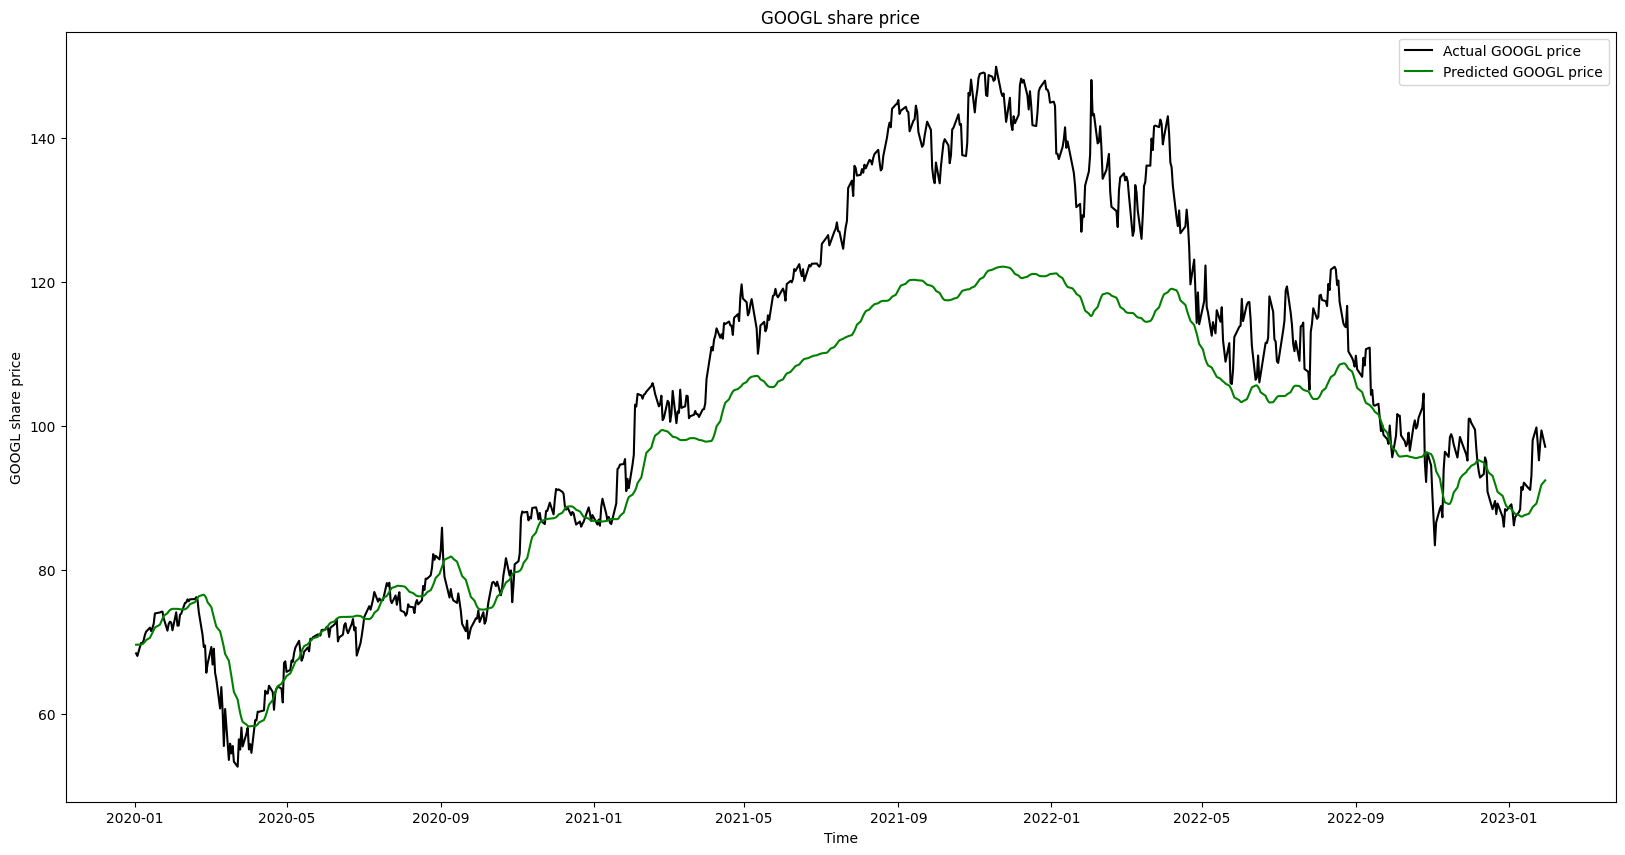

In [17]:
prediction_price = model.predict(X_test)

prediction_price = scaler.inverse_transform(prediction_price)

dates = test_data.index.to_list()

plt.figure(figsize = (20, 10))
plt.plot(dates, actual_prices, color ='black', label = f'Actual {company} price')
plt.plot(dates, prediction_price, color ='green', label = f'Predicted {company} price')
plt.title(f'{company} share price')
plt.xlabel('Time')
plt.ylabel(f'{company} share price')
plt.legend()
plt.show()

In [18]:
companies = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'FB', 'BRK.A', 'V', 'PG', 'JNJ', 'KO']


In [19]:
app = JupyterDash(__name__)

In [20]:
app.layout = html.Div([

    dcc.Graph(id = 'plot'), 
    dcc.Dropdown(id = 'dropdown', options = [{'label': company, 'value' : company} for company in companies], value = companies[0]),
    html.Button(id = 'button', n_clicks= 0, children = 'Update'),


    

])


@app.callback(Output('plot', 'figure'), [Input('button', 'n_clicks')], [State('dropdown', 'value')] )

def update_plot(n_clicks, value):

    test_data = yf.download(company, test_start, test_end)

    actual_prices = test_data['Close'].values

    dates = test_data.index.to_list()

    total_data = pd.concat((data['Close'], test_data['Close']), axis = 0)

    model_input = total_data[len(total_data)- len(test_data) - prediction_days : ].values

    model_input = model_input.reshape(-1, 1)

    model_input = scaler.transform(model_input)

    X_test = []

    for x in range(prediction_days, len(model_input)):
        X_test.append(model_input[x - prediction_days : x, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    prediction_price = model.predict(X_test)

    prediction_price = scaler.inverse_transform(prediction_price)


    prediction_price= np.squeeze(prediction_price)

    df = pd.DataFrame({'dates': dates, 'actual_prices': actual_prices, 'prediction_price': prediction_price})

    figure = px.line(df, x = 'dates', y = [' actual_prices', 'prediction_price'], title= f'{value} share price ')

    return figure
if __name__ == '__main__':
    app.run_server(debug = True)


Dash app running on http://127.0.0.1:8050/


In [21]:
len(dates)

775

In [22]:
len(actual_prices)

775

In [23]:
len(prediction_price)

775